In [1]:
import pickle,os
import numpy as np
import matplotlib.pyplot as plt

In [27]:
#use number to label areas, 2**i = visual areas index for amodal i ,2**(32+i) = invisual mask index for amodal i

def reLayerMask(mask_amodal, mask_invis):
    mask_zeros = np.zeros(mask_amodal[0].shape).astype('bool')
    labal = np.zeros(mask_amodal[0].shape).astype('uint64')
    for i in range(len(mask_amodal)):
        if i >= 32:
            continue
        if len(mask_invis[i]):
            invis = mask_invis[i] > 0
            labal[invis] |= 1 << (i + 32)
            mask_vis = mask_amodal[i] - mask_invis[i]
        else:
            mask_vis = mask_amodal[i]

        labal[mask_vis > 0] |= 1 << i

    labal = remove_small_path(labal, min_size=64)
    return labal


def remove_small_path(labal, min_size=64):
    color = np.unique(labal)
    for i in range(len(color)):
        mask = (labal == color[i])
        mask_new = morphology.remove_small_objects(mask, min_size=min_size)
        if not mask_new.max():
            labal[mask] = 0
    return labal

# get how many small picese
def get_image_labals(labal):
    labal_ids = np.unique(labal)
    if labal_ids[0] == 0:
        labal_ids = np.delete(labal_ids, 0)
    return labal_ids


# id start from 0
def objectID_to_masks(labal, id, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)

    mask_vis, mask_invis = [], []
    index_vis = np.where((labal_ids >> id) & 1 == 1)[0]
    index_invis = np.where((labal_ids >> np.uint64(id + 32)) & 1 == 1)[0]


    for items in index_vis:
        mask_vis.append(labal == labal_ids[items])
    for items in index_invis:
        mask_invis.append(labal == labal_ids[items])

    return (mask_vis, index_vis, mask_invis, index_invis)


# id start from 0, id<0 return all masks
def maskID_to_mask(labal, id, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)

    mask = []
    if id < 0:
        for items in labal_ids:
            mask.append(labal == items)
        return mask
    else:
        return labal == labal_ids[id]


def number_to_index(labal_id):
    bin_index, objectID = 0, []
    if 0 == labal_id:
        return None
    
    while labal_id:
        if labal_id & np.uint64(1):
            objectID.append(bin_index)
        bin_index += 1
        labal_id = labal_id >> np.uint64(1)
    return objectID


def objIDs_to_sindistanceLayer(object_ids,objID):
    return np.where(np.array(object_ids) == objID)[0]
    
    
def remove_last_one(number, depth):
    while number and depth:
        number = np.bitwise_and(number,np.uint64(number - 1))
        depth -= 1
    return number

def max_objectID(labal_ids):
    shift = 0
    vis = (labal_ids << np.uint64(32)) >> np.uint64(32)
    while len(np.where(vis >> np.uint64(shift) == 1)[0]) > 0:
        shift += 1
    return shift
 

# id start from 0
# return vis object id invis layer 1 - n
def maskID_to_objectIDs(labal, id, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)
    labal_id = labal_ids[id]

    vis = (labal_id << np.uint64(32)) >> np.uint64(32)  # remove highest 32 bit
    invis = labal_id >> np.uint64(32)  ## remove lowest 32 bit

    object_id_vis = number_to_index(vis)
    object_id_invis = number_to_index(invis)
    
    return object_id_vis,object_id_invis


def layer_to_mask(labal, depth, labal_ids=None):
    if labal_ids is None:
        labal_ids = get_image_labals(labal)
    mask, objectID = [], []
    vis = (labal_ids << np.uint64(32)) >> np.uint64(32)
    if 0 == depth:
        for i in range(len(vis)):
            mask.append(maskID_to_mask(labal, i))
            objectID.append(number_to_index(vis[i]))
        return (mask, objectID)

    else:
        # find (depth)th 1 from left to right, is exist have depth layer else not
        depth -= 1
        labal_inds = []
        invis = labal_ids >> np.uint64(32)
        for i in range(len(invis)):#len(invis)
            new_labal = remove_last_one(invis[i], depth)
                
            if new_labal:

                object_id = number_to_index(new_labal)#the first vis object index
                _, _, mask_invis, index_invis =objectID_to_masks(labal, object_id, labal_ids)
                

                for k in range(len(index_invis)):
                    labal_ind = labal_ids[index_invis[0][k]] 

                    new_labal_2 = remove_last_one(labal_ind >> np.uint64(32),depth)
                    if new_labal_2 and object_id == number_to_index(new_labal_2):
                        if labal_ind not in labal_inds:
                            labal_inds.append(labal_ind)
                            mask.append(mask_invis[k])
                            objectID.append(object_id)

        return (mask, objectID)
        

In [28]:
example = '../datasets/coco_amodal/train2014/COCO_train2014_000000000321.npz'
layer = np.load(example)['layer']

0 object_visID: [5] object_invisID: None
1 object_visID: [1] object_invisID: [5]
2 object_visID: [4] object_invisID: [5]
3 object_visID: [1] object_invisID: [4, 5]
4 object_visID: [2] object_invisID: [4, 5]
5 object_visID: [3] object_invisID: [4, 5]
6 object_visID: [0] object_invisID: [1, 4, 5]
7 object_visID: [2] object_invisID: [3, 4, 5]


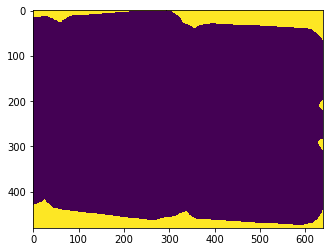

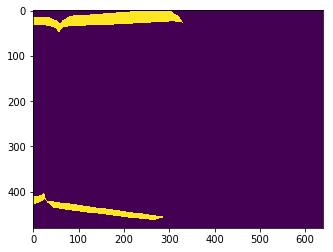

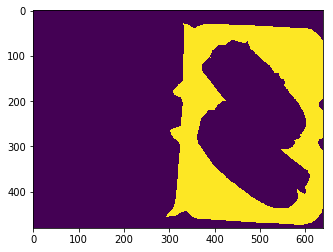

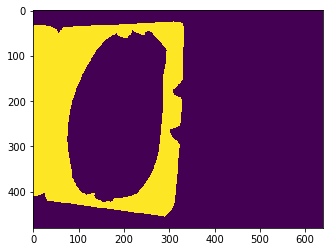

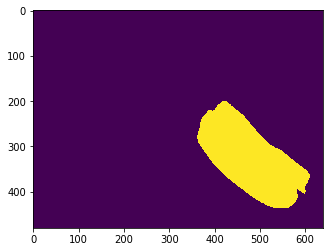

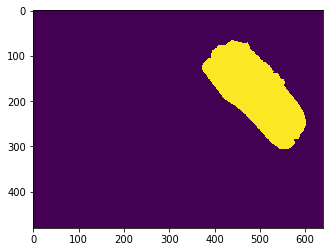

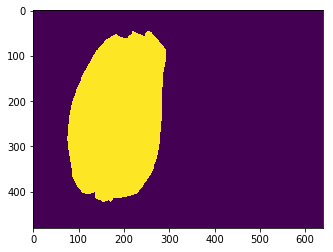

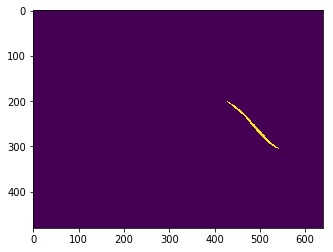

In [29]:
#check program
image_labals = get_image_labals(layer)
object_len = len(image_labals)
for i in range(object_len):
    mask = maskID_to_mask(layer,i,image_labals)
    object_id_vis,object_id_invis = maskID_to_objectIDs(layer,i,image_labals)
    print(i,'object_visID: ' + str(object_id_vis) + ' object_invisID: ' + str(object_id_invis))
    plt.figure(i)
    plt.imshow(mask)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [0], [1], [2], [5], [6], [8], [1, 8], [3, 9], [4, 9], [3, 10], [6, 10]]


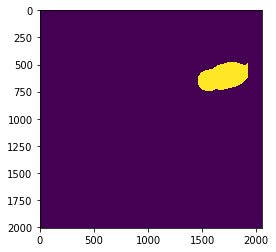

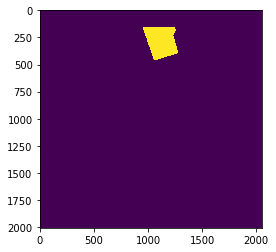

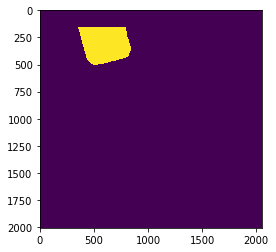

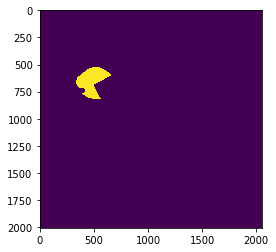

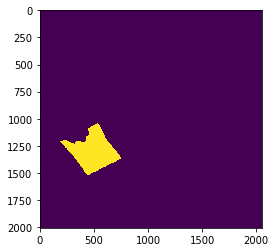

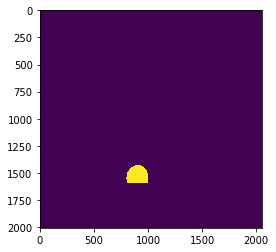

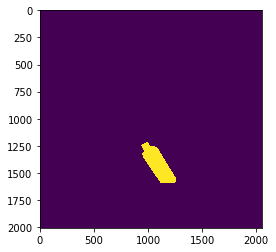

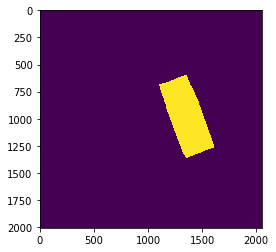

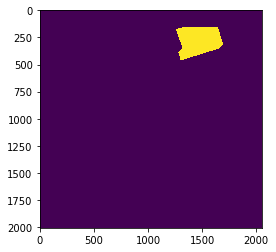

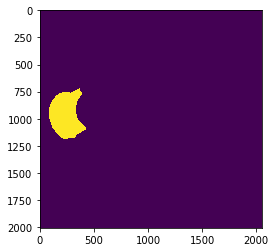

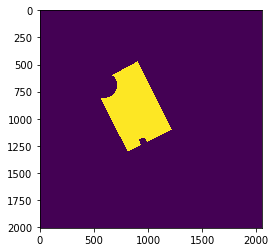

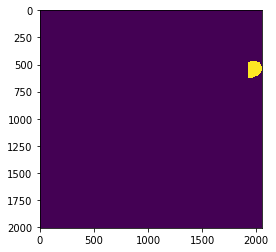

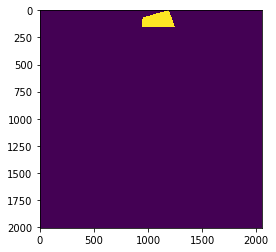

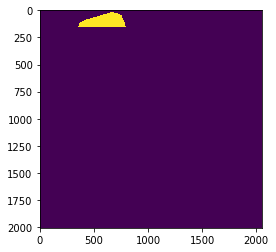

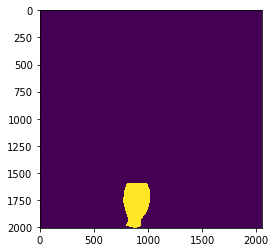

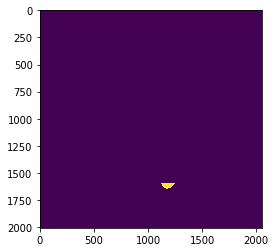

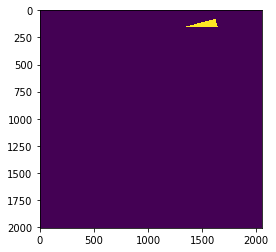

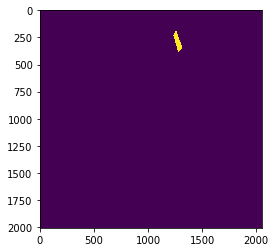

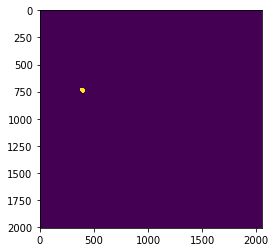

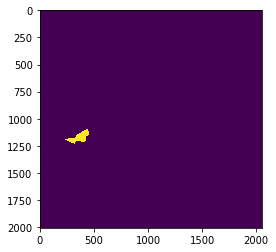

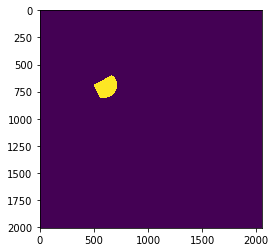

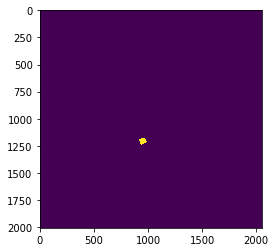

In [5]:
# vis mask with layer id
layerID = 0
data = layer_to_mask(layer,layerID,image_labals)
mask,objectID = data[0],data[1]
print(objectID)
for i in range(len(mask)):
    plt.figure(i)
    plt.imshow(mask[i])

visualizing small piceses of object: 1
visiable piceses index: [1 3]
invisiable piceses index: [6]
sinDistance orders: [0 1]


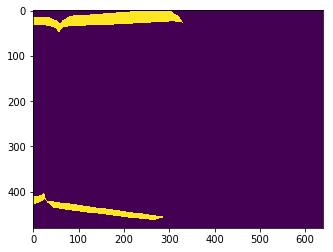

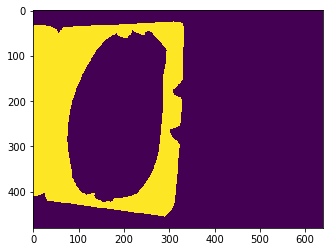

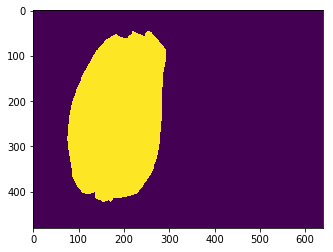

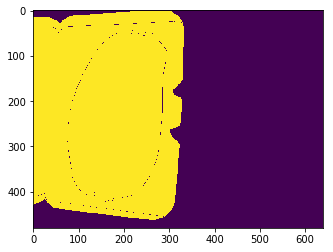

In [30]:
objectID = 1
mask_vis, index_vis, mask_invis, index_invis = objectID_to_masks(layer, objectID, image_labals)
mask_all = None

print('visualizing small piceses of object: '+ str(objectID))
for i,item in enumerate(mask_vis):
    plt.figure()
    plt.imshow(item)
    if 0 == i:
        mask_all = item
    else:
        mask_all += item

for i,item in enumerate(mask_invis):
    plt.figure()
    plt.imshow(item)
    mask_all += item
plt.figure()
plt.imshow(mask_all)

distancesLayers = np.array([0])
for item in index_invis:
    object_id_vis,object_id_invis = maskID_to_objectIDs(layer,item,image_labals)
    distancesLayers = np.append(distancesLayers,objIDs_to_sindistanceLayer(object_id_invis,objectID) + 1)
    
print('visiable piceses index: ' + str(index_vis))
print('invisiable piceses index: ' + str(index_invis))
print('sinDistance orders: ' + str(distancesLayers))

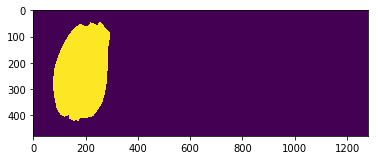

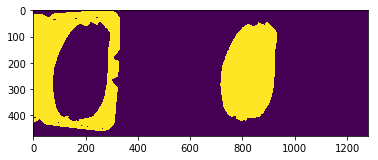

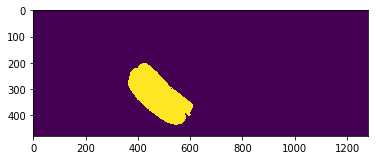

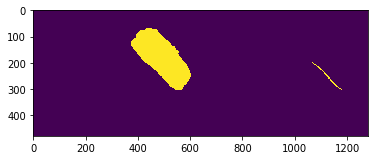

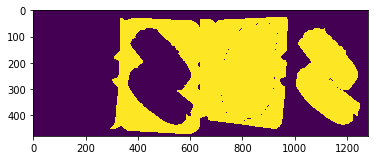

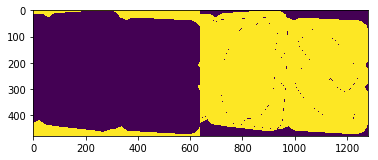

In [98]:
###############################  check data loader  #########################
image_info = {}
image_info["height"],image_info["width"] = 480,640
class_ids, occlude_rates = [], []
instance_masks, invisiable_mask, visiable_mask = [], [], []
image_labals = get_image_labals(layer)
object_len = max_objectID(image_labals)
for i in range(object_len):
    mask_vis, index_vis, mask_invis, index_invis = objectID_to_masks(layer, i, image_labals)

    mask_vis_all = np.zeros((image_info["height"], image_info["width"])).astype('bool')
    for item in mask_vis:
        mask_vis_all += item
        

    mask_invis_all = np.zeros((image_info["height"], image_info["width"])).astype('bool')
    if len(index_invis) > 0:
        distancesLayers = np.zeros(len(mask_vis))
        for j in range(len(index_invis)):
            object_id_vis, object_id_invis = maskID_to_objectIDs(layer, index_invis[j], image_labals)
            distancesLayers = np.append(distancesLayers, objIDs_to_sindistanceLayer(object_id_invis, i) + 1)
            mask_invis_all += mask_invis[j]

    visiable_mask.append(mask_vis_all)
    invisiable_mask.append(mask_invis_all)
    instance_masks.append(mask_vis_all + mask_invis_all)
    class_ids.append([1])
    
for i in range(len(visiable_mask)):
    plt.figure()
    plt.imshow(np.hstack((visiable_mask[i],invisiable_mask[i])))

In [109]:
NUM_CLASSES = 3
def load_layer2(path):
    layer = np.load(path)['layer']
    width,height = layer.shape[1],layer.shape[0]
    class_ids, occlude_rates = [], []
    instance_masks, invisiable_mask, visiable_mask = [], [], []
    image_labals = get_image_labals(layer)
    object_len = max_objectID(image_labals)
    for i in range(object_len):
        mask_vis, index_vis, mask_invis, index_invis = objectID_to_masks(layer, i, image_labals)
        mask_all = np.zeros((height, width)).astype('bool')
        mask_vis_all = np.zeros((height, width)).astype('bool')
        for item in mask_vis:
            mask_vis_all += item
            mask_all += item

        mask_invis_layer = np.zeros((height, width,NUM_CLASSES-2)).astype('bool')
        if len(index_invis) > 0:
            for j in range(len(index_invis)):
                object_id_vis, object_id_invis = maskID_to_objectIDs(layer,index_invis[j], image_labals)

                distancesLayer = objIDs_to_sindistanceLayer(object_id_invis, i)+1
                
                if len(distancesLayer)>0:
                    
                    if distancesLayer >= NUM_CLASSES-1-1:
                        mask_invis_layer[:,:,-1] +=  mask_invis[j]
                    else:
                        mask_invis_layer[...,distancesLayer[0]] += mask_invis[j]
                    mask_all += mask_invis[j]
                    

        visiable_mask.append(mask_vis_all)
        invisiable_mask.append(mask_invis_layer)
        instance_masks.append(mask_all)
        class_ids.append(1)

    # Pack instance masks into an array
    if len(class_ids):
        mask = np.stack(instance_masks, axis=2)
        mask_invis = np.stack(invisiable_mask, axis=3)
        mask_vis= np.stack(visiable_mask, axis=2)
        class_ids = np.array(class_ids, dtype=np.int32)
        
    for i in range(len(visiable_mask)):
        plt.figure()
        plt.imshow(np.hstack((mask_vis[...,i],mask_invis[...,0,i],mask[...,i])))
    return mask, class_ids,mask_vis,mask_invis
mask, class_ids,mask_vis,mask_invis = load_layer2(example)

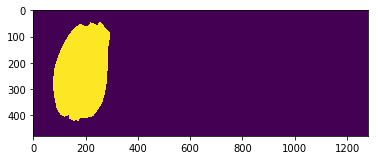

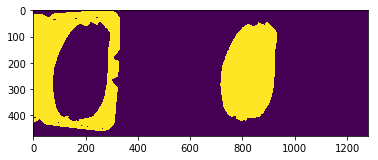

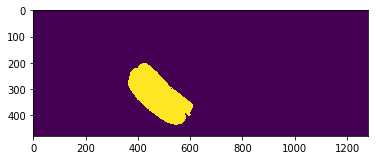

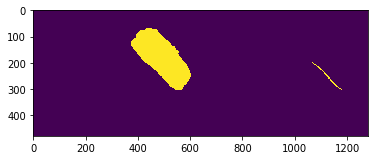

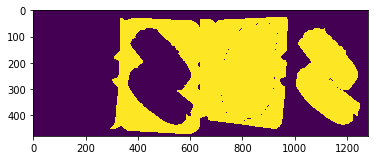

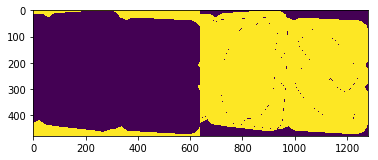

In [119]:
NUM_CLASSES = 3
def load_layer2(path):
    layer = np.load(path)['layer']
    width,height = layer.shape[1],layer.shape[0]
    class_ids = []
    mask_layers= []
    image_labals = get_image_labals(layer)
    object_len = max_objectID(image_labals)
    for i in range(object_len):
        mask_vis, index_vis, mask_invis, index_invis = objectID_to_masks(layer, i, image_labals)
        mask_layer = np.zeros((height, width,NUM_CLASSES-1)).astype('bool')

        for item in mask_vis:
            mask_layer[...,0] += item

        if len(index_invis) > 0:
            for j in range(len(index_invis)):
                object_id_vis, object_id_invis = maskID_to_objectIDs(layer,index_invis[j], image_labals)
                distancesLayer = objIDs_to_sindistanceLayer(object_id_invis, i)+1

                if distancesLayer >= NUM_CLASSES-1-1:
                    mask_layer[:,:,-1] +=  mask_invis[j]
                else:
                    mask_layer[...,distancesLayer[0]] += mask_invis[j]
                 

        mask_layers.append(mask_layer)
        class_ids.append(1)

    # Pack instance masks into an array
    if len(class_ids):
        mask_layers = np.stack(mask_layers, axis=3)
        class_ids = np.array(class_ids, dtype=np.int32)
    
    for i in range(len(visiable_mask)):
            
        plt.figure()
        plt.imshow(np.hstack([mask_layers[...,j,i] for j in range(mask_layers.shape[2])]))

    return mask_layers,class_ids
mask_layers,class_ids = load_layer2(example)

In [117]:
mask_layers.shape

(480, 640, 2, 6)